In [17]:
import numpy as np
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import GPy

In [10]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [11]:
grid = pd.read_csv('combined.csv')

In [12]:
grid_dates_corrected = []

for date in grid.SETTLEMENT_DATE.values:
    grid_dates_corrected.append(datetime.date(year=int(date[7:]), month=months[date[3:6].capitalize()], day=int(date[:2])))

grid['DATE'] = grid_dates_corrected

In [13]:
grid_average = grid.groupby('DATE').agg(DEMAND_AVERAGE=pd.NamedAgg('ND',aggfunc=np.mean)).reset_index()

year = []; doy = []
for date in grid_average.DATE.values:
    year.append(date.year)
    doy.append(date.timetuple().tm_yday)

grid_average['YEAR'] = year; grid_average['DOY'] = doy

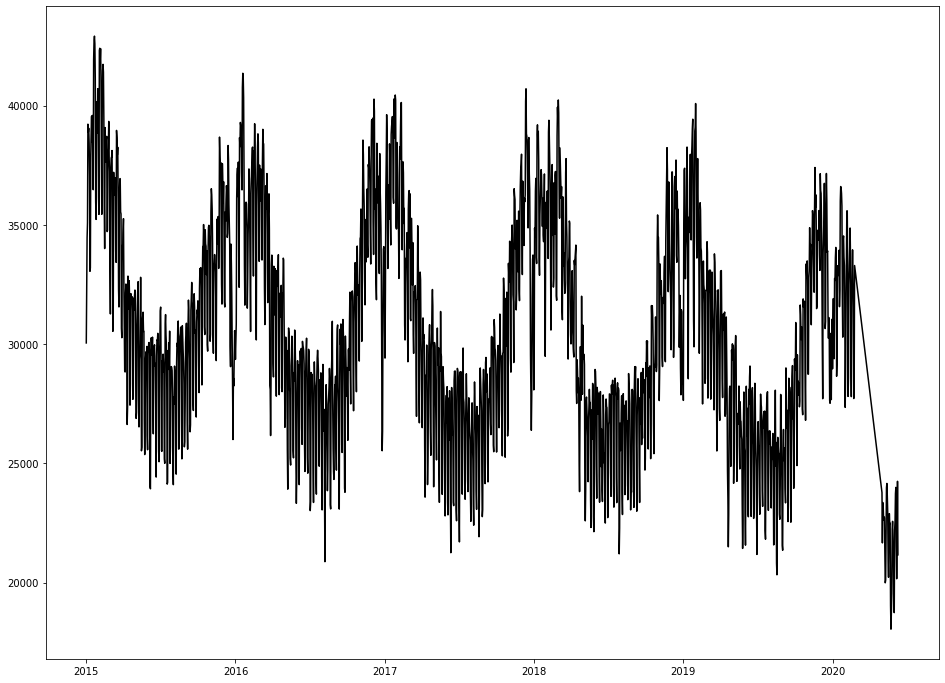

In [14]:
plt.figure(figsize=(16,12))
plt.plot(grid_average.DATE, grid_average.DEMAND_AVERAGE, c='k')
plt.show()

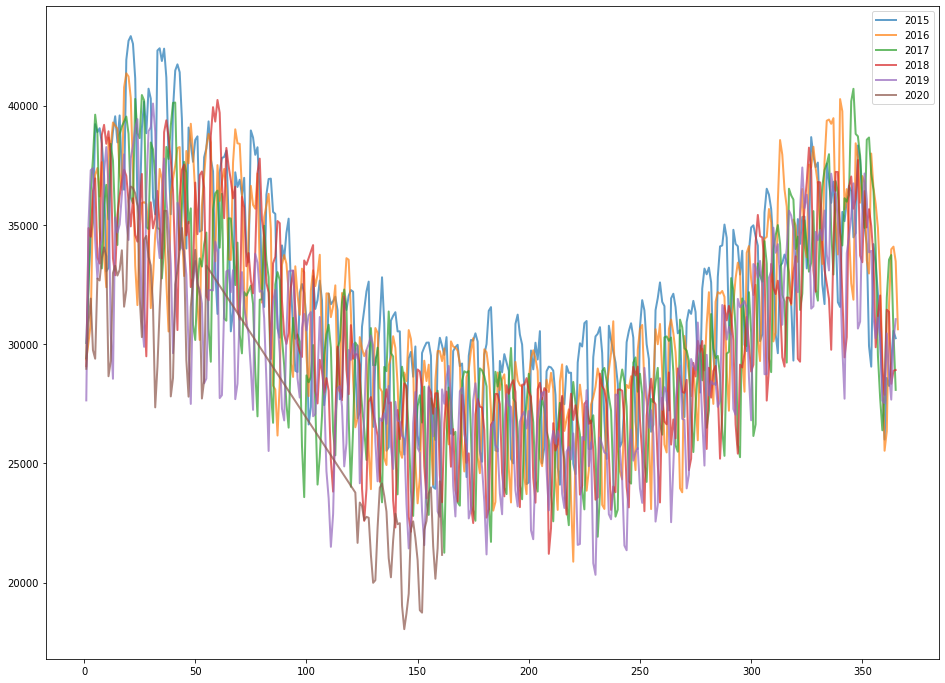

In [15]:
plt.figure(figsize=(16,12))
for year in np.unique(grid_average.YEAR.values):
    plt.plot(grid_average.DOY[grid_average.YEAR.values==year], grid_average.DEMAND_AVERAGE[grid_average.YEAR.values==year], linewidth=2, alpha=0.7, label=str(year))
plt.legend()
plt.show()

In [18]:
OFFSET = 0
X = []
for year in np.unique(grid_average.YEAR.values):
    DOY = OFFSET + grid_average.DOY[grid_average.YEAR.values==year]
    X += [i for i in DOY]
    OFFSET += max(grid_average.DOY[grid_average.YEAR.values==year])
X = np.expand_dims(np.array(X)/365, axis=1)
Y = np.expand_dims(grid_average.DEMAND_AVERAGE.values/1000, axis=1)

In [19]:
#kernel = GPy.kern.Bias(input_dim=1, variance=1) + GPy.kern.Linear(input_dim=1) \
#        + GPy.kern.RBF(input_dim=1, lengthscale=100)*GPy.kern.PeriodicExponential(input_dim=1, lengthscale=1/52, period=1)

kernel = GPy.kern.Bias(input_dim=1, variance=1) + GPy.kern.RBF(input_dim=1, lengthscale=50) \
        + GPy.kern.RBF(input_dim=1, lengthscale=100)*GPy.kern.PeriodicExponential(input_dim=1, lengthscale=1/52, period=1) \

m = GPy.models.GPRegression(X,Y,kernel)
print(m)


Name : GP regression
Objective : 10235.948520386422
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  GP_regression.                            |                 value  |  constraints  |  priors
  sum.bias.variance                         |                   1.0  |      +ve      |        
  sum.rbf.variance                          |                   1.0  |      +ve      |        
  sum.rbf.lengthscale                       |                  50.0  |      +ve      |        
  sum.mul.rbf.variance                      |                   1.0  |      +ve      |        
  sum.mul.rbf.lengthscale                   |                 100.0  |      +ve      |        
  sum.mul.periodic_exponential.variance     |                   1.0  |      +ve      |        
  sum.mul.periodic_exponential.lengthscale  |  0.019230769230769232  |      +ve      |        
  sum.mul.periodic_exponential.period       |                   1.0  |      +ve      |        
  

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f4998032828>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f49980327b8>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f4998032dd8>]}

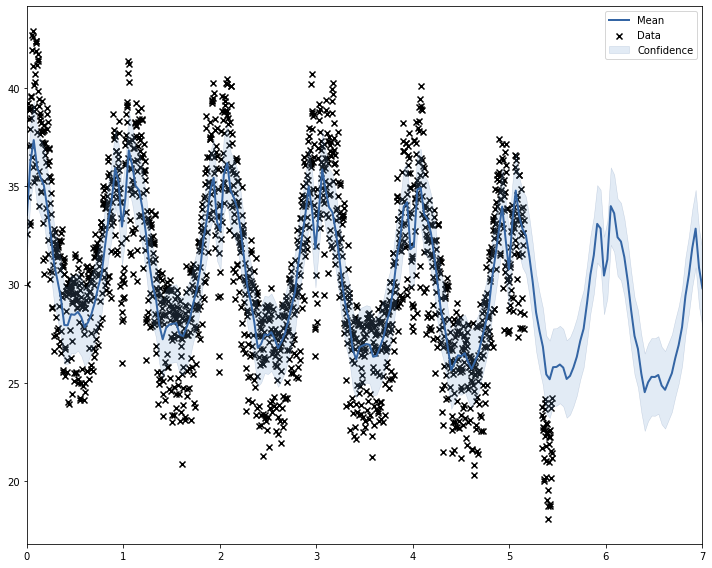

In [20]:
m.plot(figsize=(10,8), plot_limits=[0,7])

In [ ]:
m.optimize()
print(m)

In [ ]:
m.plot(figsize=(10,8), plot_limits=[0,7])